# Question 6: RNN - LSTM - NLP
- Use Clothing, Shoes and Jewelry dataset (file Clothing_Shoes_and_Jewelry_5.json in reviews_Clothing_Shoes_and_Jewelry_5.json.gz) to build a model to predict customer sentiment (You can categories into 3 groups such as like: 4 or 5 stars, dislike: 1 or 2 stars, neutral :3 stars; or categories into 2 groups...) (overall column) based on their review (reviewText column)

- Read more information here: http://jmcauley.ucsd.edu/data/amazon/


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
%cd'/content/gdrive/My Drive/LDS8_K270_ONLINE_VuThiHa/LDS8_K270_VuThiHa_Cuoi_ky/'

/content/gdrive/My Drive/LDS8_K270_ONLINE_VuThiHa/LDS8_K270_VuThiHa_Cuoi_ky


In [5]:
import json
 
df = pd.read_json('reviews_Clothing_Shoes_and_Jewelry_5.json.gz',lines=True,
        compression='gzip')

In [6]:
print(df.shape)
df.head(5)

(278677, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,1394841600,"03 15, 2014"


In [7]:
df.tail()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
278672,A2DG63DN704LOI,B00KKXCJQU,ESlayd,"[0, 1]",I don't normally go ga-ga over a product very ...,5,These have literally changed the way I travel!,1403568000,"06 24, 2014"
278673,A1EVV74UQYVKRY,B00KKXCJQU,K. Groh,"[0, 0]",I've been traveling back and forth to England ...,5,Wonderful for Better Packing,1403740800,"06 26, 2014"
278674,A1UQBFCERIP7VJ,B00KKXCJQU,Margaret Picky,"[1, 1]",These are very nice packing cubes and the 18 x...,5,"Convenient, lightweight, and durable",1402185600,"06 8, 2014"
278675,A22CW0ZHY3NJH8,B00KKXCJQU,Noname,"[2, 2]",I am on vacation with my family of four and th...,5,Holds Up Well In Real World Test,1404691200,"07 7, 2014"
278676,A30VWT3R25QAVD,B00KKXCJQU,"THE-DEADLY-DOG ""Living and Loving Life.""","[0, 1]",When I signed up to receive a free set of Shac...,5,Don't Travel? Still Way too Useful for 'Averag...,1403481600,"06 23, 2014"


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278677 entries, 0 to 278676
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      278677 non-null  object
 1   asin            278677 non-null  object
 2   reviewerName    278225 non-null  object
 3   helpful         278677 non-null  object
 4   reviewText      278677 non-null  object
 5   overall         278677 non-null  int64 
 6   summary         278677 non-null  object
 7   unixReviewTime  278677 non-null  int64 
 8   reviewTime      278677 non-null  object
dtypes: int64(2), object(7)
memory usage: 19.1+ MB


In [9]:
df['overall_cat'] = df['overall']

In [10]:
for i in range(len(df)):
  if df['overall'][i] >= 4:
    df['overall_cat'][i] = 'Like'
  elif df['overall'][i] <=2:
    df['overall_cat'][i] = 'Not_Like'
  else:
    df['overall_cat'][i] = 'Neutral'

In [11]:
data = df[['reviewText','overall_cat']]

In [12]:
data['reviewText'] = data['reviewText'].astype('str')

In [13]:
data = data.replace(' ', np.nan) 

In [14]:
data.isnull().sum()

reviewText     0
overall_cat    0
dtype: int64

In [25]:
data.head()

,reviewText,overall_cat
0,This is a great tutu and at a really great pri...,Like
1,I bought this for my 4 yr old daughter for dan...,Like
2,What can I say... my daughters have it in oran...,Like
3,"We bought several tutus at once, and they are ...",Like
4,Thank you Halo Heaven great product for Little...,Like


In [26]:
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
STOPWORDS = set(stopwords.words('english'))

# Remove features
def remove_features(data_str):
    # import string library function 
    import string 
    # compile regex
    url_re = re.compile('https?://(www.)?\w+\.\w+(/\w+)*/?')
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    num_re = re.compile('(\\d+)')
    mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
    # convert to lowercase
    data_str = data_str.lower()
    # remove hyperlinks
    data_str = url_re.sub(' ', data_str)
    # remove @mentions
    data_str = mention_re.sub(' ', data_str)
    # remove puncuation
    data_str = punc_re.sub(' ', data_str)
    # remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
    # remove non a-z 0-9 characters and words shorter than 3 characters
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word) and len(word) > 2:
                cleaned_str = word
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word) and len(word) > 2:
                cleaned_str = cleaned_str + ' ' + word
            else:
                cleaned_str += ' '
        list_pos += 1
    return cleaned_str

In [33]:
data = data.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()
    text = BAD_SYMBOLS_RE.sub('', text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [35]:
data['clean_review'] = data['reviewText'].apply(remove_features)

In [36]:
data['clean_review'] = data['clean_review'].apply(clean_text)

In [37]:
data['clean_review'] = data['clean_review'].str.replace('\d+', '')

In [38]:
data.head()

,reviewText,overall_cat,clean_review
0,This is a great tutu and at a really great pri...,Like,great tutu really great price look cheap glad ...
1,I bought this for my 4 yr old daughter for dan...,Like,bought old daughter dance class wore today fir...
2,What can I say... my daughters have it in oran...,Like,say daughters orange black white pink thinking...
3,"We bought several tutus at once, and they are ...",Like,bought several tutus got high reviews sturdy s...
4,Thank you Halo Heaven great product for Little...,Like,thank halo heaven great product little girls g...


In [39]:
# df['v1'] = df['CLASS'].map(lambda x: )
data['WORDS'] = data['clean_review'].map(lambda x: len(x.split()))
data.head()

,reviewText,overall_cat,clean_review,WORDS
0,This is a great tutu and at a really great pri...,Like,great tutu really great price look cheap glad ...,15
1,I bought this for my 4 yr old daughter for dan...,Like,bought old daughter dance class wore today fir...,26
2,What can I say... my daughters have it in oran...,Like,say daughters orange black white pink thinking...,31
3,"We bought several tutus at once, and they are ...",Like,bought several tutus got high reviews sturdy s...,37
4,Thank you Halo Heaven great product for Little...,Like,thank halo heaven great product little girls g...,46


In [40]:
data.groupby("overall_cat").mean("WORDS")

,WORDS
overall_cat,
Like,27.831604
Neutral,29.636779
Not_Like,30.005065


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
X = data['clean_review'] # input 
y = data['overall_cat'] # output

In [44]:
y1 = pd.get_dummies(y)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y1,test_size=0.3)

## Process the data
- Tokenize the data and convert the text to sequences
- Add padding to ensure that all the sequences have the same shape
- There are many ways of taking the max_len and here an arbitrary length of 150 is chosen

In [46]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)

sequences = tok.texts_to_sequences(X_train)
sequences_matrix=sequence.pad_sequences(sequences, maxlen=max_len)

In [47]:
print(sequences[:2])

[[3, 207, 92, 208, 1, 629, 182, 35, 4, 77, 465, 1, 7, 27, 72, 409, 98, 7, 324, 19, 169, 583, 764, 249], [17, 339, 117, 4, 6, 28, 434, 659, 597, 659, 434, 60, 371, 36, 123, 6, 172, 4, 159, 44]]


In [48]:
sequences_matrix[:2]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   3, 207,  92, 208,
          1, 629, 182,  35,   4,  77, 465,   1,   7,  27,  72, 409,  98,
          7, 324,  19, 169, 583, 764, 249],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       

## RNN

In [49]:
# model = RNN()
model = Sequential()
model.add(Embedding(max_words,50))
model.add(LSTM(64))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

In [50]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 96,851
Trainable params: 96,851
Non-trainable params: 0
_________________________________________________________________


In [53]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

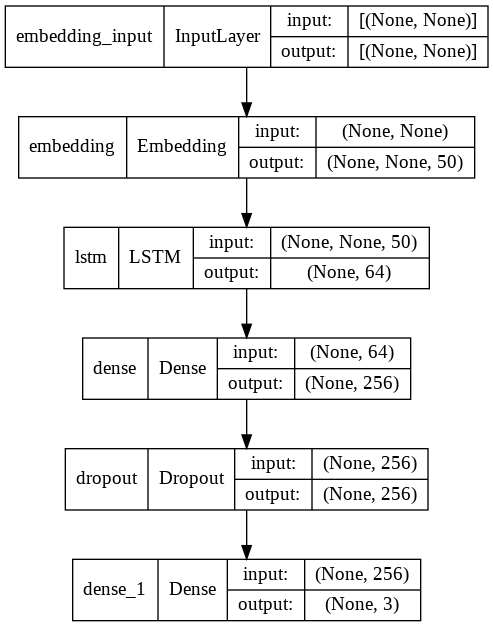

In [54]:
plot_model(model, to_file='LSTM_NLP_model.png', show_shapes=True)
Image(filename='LSTM_NLP_model.png')

### Tính tham số
- embedding layer = in x out = 1000x5 = 50.000
- LSTM layer=[(num_units + input_dim +1) x num_units] x 4 = (64+50+1)x64x4 = 29.440
- dense layer = in x out + bias = 64*256+256 = 16640
- dropout = 0
- dense output layer = 256*1+1 = 257

In [55]:
history = model.fit(sequences_matrix,y_train,
                    batch_size=128,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss',patience=5)])

Epoch 1/50
1220/1220 [==============================] - 18s 11ms/step - loss: 0.2810 - accuracy: 0.8237 - val_loss: 0.2785 - val_accuracy: 0.8270
Epoch 2/50
1220/1220 [==============================] - 13s 11ms/step - loss: 0.2573 - accuracy: 0.8350 - val_loss: 0.2600 - val_accuracy: 0.8301
Epoch 3/50
1220/1220 [==============================] - 13s 11ms/step - loss: 0.2514 - accuracy: 0.8382 - val_loss: 0.2566 - val_accuracy: 0.8322
Epoch 4/50
1220/1220 [==============================] - 13s 11ms/step - loss: 0.2471 - accuracy: 0.8407 - val_loss: 0.2564 - val_accuracy: 0.8330
Epoch 5/50
1220/1220 [==============================] - 13s 11ms/step - loss: 0.2433 - accuracy: 0.8434 - val_loss: 0.2523 - val_accuracy: 0.8345
Epoch 6/50
1220/1220 [==============================] - 13s 11ms/step - loss: 0.2396 - accuracy: 0.8452 - val_loss: 0.2550 - val_accuracy: 0.8363
Epoch 7/50
1220/1220 [==============================] - 14s 11ms/step - loss: 0.2367 - accuracy: 0.8475 - val_loss: 0.2544 -

In [56]:
#test
test_sequences=tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)


In [57]:
accr = model.evaluate(test_sequences_matrix,y_test)

2613/2613 [==============================] - 10s 4ms/step - loss: 0.2585 - accuracy: 0.8405


In [60]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.259
  Accuracy: 0.840


In [62]:
# Save the result
from tensorflow.keras.models import load_model
model.save('LSTM_baithi_model.h5')

## Make new predictions

In [63]:
type(X_test)

pandas.core.series.Series

In [64]:
X_new = pd.Series(data = ["This cloth is not good as other. It is too long sleeve and the quality is really bad", 
                          " I like the color of the skirt. it compliments my skin and body"])
test_sequences_new = tok.texts_to_sequences(X_new)
test_sequences_matrix_new = sequence.pad_sequences(test_sequences_new, maxlen=max_len)

In [65]:
X_new

0    This cloth is not good as other. It is too lon...
1     I like the color of the skirt. it compliments...
dtype: object

In [66]:
test_sequences_matrix_new

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        956,   7,  35, 750,  22,  14, 228],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       

In [67]:
model.predict(test_sequences_matrix_new)

array([[2.7766725e-01, 3.7507507e-01, 3.4725764e-01],
       [9.9998891e-01, 9.8890559e-06, 1.2007282e-06]], dtype=float32)